In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import signal
import os
import scipy.stats as stats

In [2]:
dfs = {}
traces_dir = 'syn_traces'
for root,dirs,files in os.walk(traces_dir):
    for file in files:
        print(file[:-4])
        dfs[file[:-4]] = pd.read_csv(traces_dir + "/" + file)

da001_syn
da10_syn
da3ops_syn
da3_syn
la30hz_syn
la3_syn


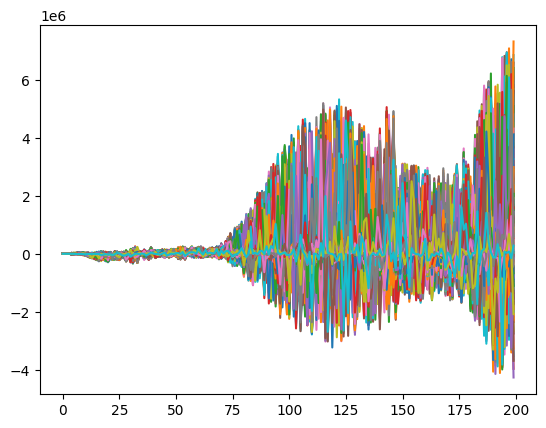

In [5]:
def plot_traces(df, right_bound=100, label=None):
    if label != None:
        for row in df.itertuples():
            if row.Label == label:
                plt.plot(list(row[:right_bound]))
    else:
        for row in df.itertuples():
            plt.plot(list(row[:right_bound]))
        
plot_traces(dfs['da3_syn'], 200, 1)

[8.24533552e-08 4.12266776e-07 8.24533552e-07 8.24533552e-07
 4.12266776e-07 8.24533552e-08]
[ 1.         -4.74585884  9.01543009 -8.56867595  4.07461224 -0.77550491]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


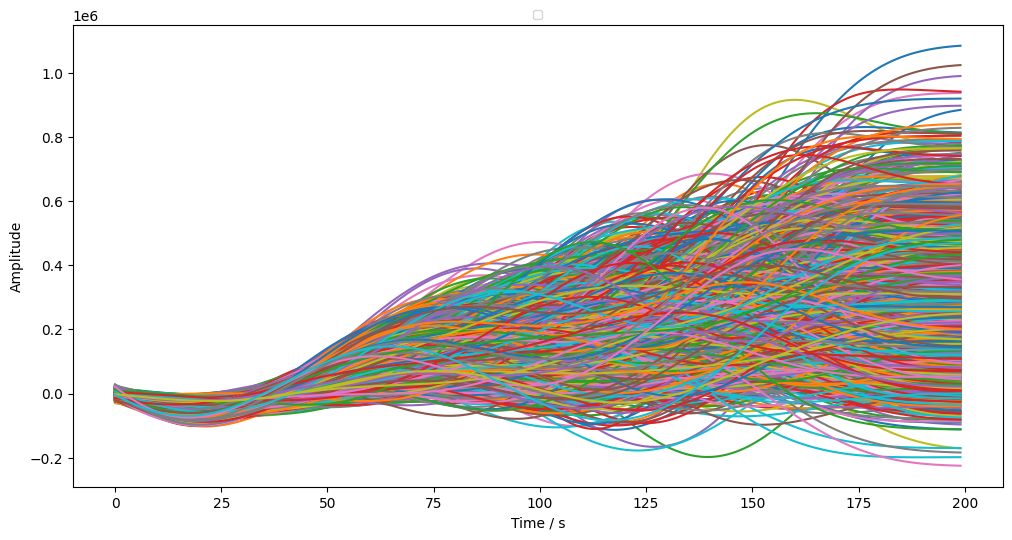

In [3]:
def apply_filter(df, right_bound=100):
    b, a = signal.iirfilter(5, Wn=5, fs=400, btype="low", ftype="butter")
    print(b, a, sep="\n")

    yraw = df
    y_lfilter = signal.filtfilt(b, a, yraw)

    plt.figure(figsize=[12, 6])

    for row in y_lfilter:
        plt.plot(list(row[:right_bound]))

    plt.xlabel("Time / s")
    plt.ylabel("Amplitude")
    plt.legend(loc="lower center", bbox_to_anchor=[0.5, 1],
               ncol=2, fontsize="smaller")
    
apply_filter(dfs['da3_syn'], 200)

## Apply Gaussian transformation to abnormal traces

mu 47531.728452907955
sigma 72232.49795306752


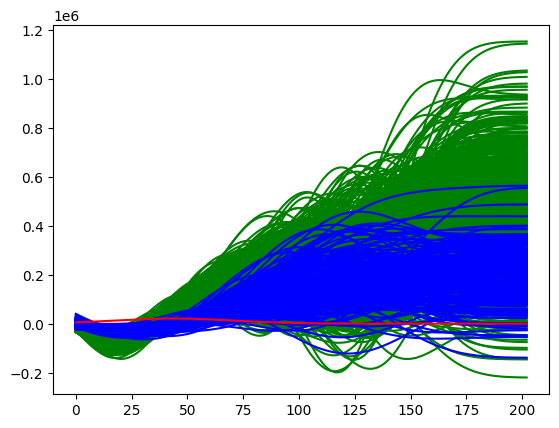

In [4]:
df = dfs['da3_syn']

bn, an = signal.iirfilter(10, Wn=5, fs=300, btype="low", ftype="butter")
y_lfilter_n = signal.filtfilt(bn, an, df[df['Label'] == 0])

ba, aa = signal.iirfilter(5, Wn=4, fs=400, btype="low", ftype="butter")
y_lfilter_ab = signal.filtfilt(ba, aa, df[df['Label'] == 1])


for row in y_lfilter_n[:, :]:
    plt.plot(list(row[:203]), color='green')
    
for row in y_lfilter_ab[100:300, :]:
    plt.plot(list(row[:203]), color='blue')
    
# fit curve to normal traces pattern 
mu = np.average(y_lfilter_ab[:, 25:100])
sigma = np.std(y_lfilter_ab[:, 25:100])
print("mu", mu)
print("sigma", sigma)
gauss_curve_range = np.linspace(0, mu + 7*sigma, 203)
gauss_curve = 3.8e9*stats.norm.pdf(gauss_curve_range, mu+1.0*sigma, sigma)

def apply_gauss(init_curves, gauss_curve):
    adj_curves = []
    for i in range(len(init_curves)):
        adj_curves.append(np.array(init_curves[i]) + gauss_curve)
    return adj_curves

y_lfilter_ab_adj = apply_gauss(y_lfilter_ab, gauss_curve)

#for adj_c in y_lfilter_ab_adj:
 #   plt.plot(adj_c, color='grey')
    
plt.plot(gauss_curve, color='red')
plt.show()

## Add Noise

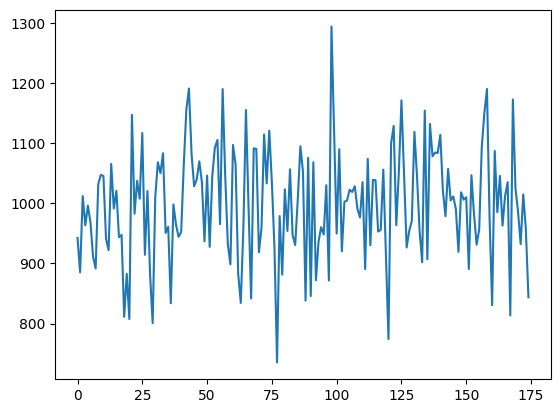

In [37]:
noise = np.random.normal(1000,100,175)
plt.plot((noise))

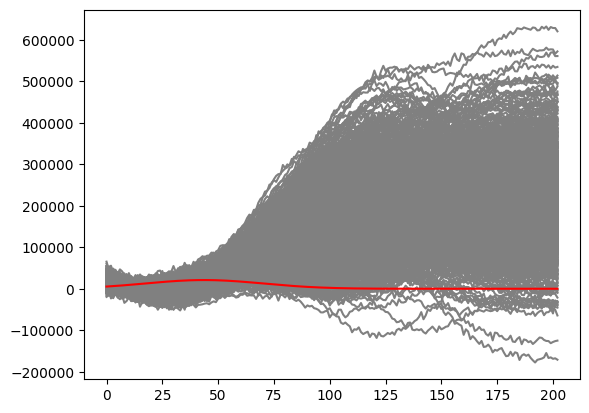

In [47]:
y_filter_ab_adj_noised = []
for adj_c in y_lfilter_ab_adj[0:]:
    y_filter_ab_adj_noised.append(adj_c + np.random.normal(10000,15000,203))
    plt.plot(adj_c + np.random.normal(10000,5000,203), color='grey')
    
plt.plot(gauss_curve, color='red')
plt.show()

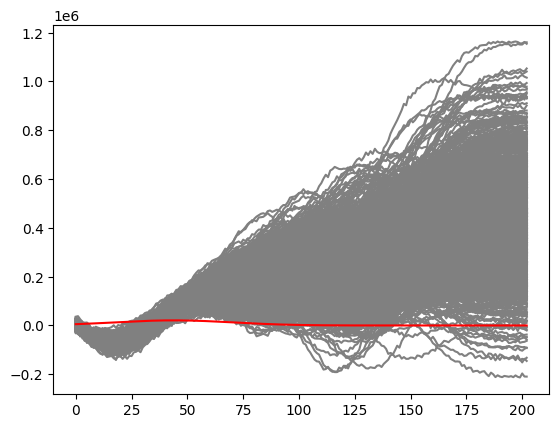

In [49]:
y_filter_norm_noised = []
for adj_c in y_lfilter_n[0:]:
    y_filter_norm_noised.append(adj_c + np.random.normal(10000,15000,203))
    plt.plot(adj_c + np.random.normal(10000,5000,203), color='grey')
    
plt.plot(gauss_curve, color='red')
plt.show()

In [50]:
columns = [i for i in range(len(y_filter_ab_adj_noised[0]))]
new_df_ab = pd.DataFrame(data = y_filter_ab_adj_noised, columns = columns)
new_df_ab.insert(0, 'Label', value=1)
new_df_ab

,Label,0,1,2,3,4,5,6,7,8,...,193,194,195,196,197,198,199,200,201,202
0,1,68291.606230,46264.942010,33319.798442,15317.895167,36043.740336,46073.395422,8377.865621,7717.252560,11165.889747,...,48778.557837,16184.409841,45993.140326,30373.772956,37600.849794,62342.835293,37793.746194,64115.955959,42949.699494,65027.953997
1,1,-28925.094585,12475.526932,244.450078,2423.231549,-7380.791426,18130.183265,-13244.050824,-16782.770422,27348.165242,...,5563.774230,21861.539682,15428.368493,16871.306481,7760.569065,18022.715643,-2779.915729,19486.700612,-2638.574212,16999.164201
2,1,30205.830625,2442.466626,27996.700949,28697.691365,28274.580934,11864.506144,38269.508349,42103.484691,-27359.300082,...,254242.771028,230770.650981,279316.727595,250526.162667,279451.081373,305170.815530,280390.509810,263410.393965,255888.902815,254508.553062
3,1,12214.242166,18504.110899,-11899.514891,7121.788302,-17034.462033,-1384.425249,-14916.306319,440.781965,-300.191920,...,34555.599876,36439.974826,46368.276246,24208.611381,48224.257045,45173.755170,42495.441428,56982.189027,43641.661303,29473.692185
4,1,-657.611498,56197.284237,25583.304286,23895.058158,15049.432525,25673.779264,-22375.887434,19317.504042,3652.935657,...,379365.087584,358373.330931,357781.939229,396555.222533,359786.886455,382986.857631,388208.107843,401860.212465,354735.892174,387880.837580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,-1823.403293,20268.865682,5567.724342,36047.578296,5977.015862,7941.836506,-15035.108450,-22290.469528,7234.856617,...,291335.101275,319053.084609,311026.048857,300303.924017,293442.123804,289274.084915,289441.136938,341540.019118,299750.693400,308630.426651
996,1,37558.472287,16968.564620,20772.434110,20438.058543,3649.580674,12353.570676,2431.740097,6401.970255,37917.197053,...,112182.406505,113417.464467,105977.591829,80618.418449,92632.950320,126045.757362,109317.622264,114179.288905,74437.565014,110459.261482
997,1,37594.914446,12073.049622,36086.820055,33123.050139,32899.553641,33208.062794,30440.305716,9856.208418,16594.719528,...,407000.340278,405276.733604,399722.056382,383568.442456,420331.437781,432982.742753,433253.102521,414222.243329,396678.910771,423366.955882
998,1,11838.437665,53653.748515,29577.805933,18975.671298,16319.544103,22395.116930,3972.965958,4432.523781,2505.722681,...,109294.957367,156438.604747,125780.703725,105062.712401,134530.687899,136132.239253,109712.687680,118063.709565,123031.644820,113090.371703


In [51]:
new_df_norm = pd.DataFrame(data = y_filter_norm_noised, columns = columns)
new_df_norm.insert(0, 'Label', value=0)
new_df_norm

,Label,0,1,2,3,4,5,6,7,8,...,193,194,195,196,197,198,199,200,201,202
0,0,16890.683181,8412.586294,8803.904003,-17399.729760,-29895.336186,-18815.391091,-46928.371410,-31523.144650,-49564.586093,...,158696.149540,150966.361278,144329.280516,132350.890390,150428.984546,160639.202930,143335.908223,139408.028187,154962.176313,149555.244064
1,0,39304.140511,4161.752105,14355.064085,-2622.516615,-17694.113343,-15986.342852,-21012.350173,-67920.518223,-49901.578312,...,642436.748917,640073.832274,645707.569737,648251.456443,653800.628263,632075.901002,645849.237588,639005.571899,644713.635089,662779.003156
2,0,9334.081785,-6437.149248,-9168.337003,-28592.667400,-31755.890886,-45275.739788,-48131.263495,-69371.908637,-78385.178782,...,113336.183873,135659.582163,105595.594318,97148.943877,111340.358278,110802.380613,118761.282513,105447.759798,109638.133331,138968.659377
3,0,26403.934167,24501.375210,14073.451733,6933.557604,-13292.452149,-7025.240450,-16211.415873,-14721.617940,-26146.018695,...,470958.040106,440852.103223,471634.405548,471382.323891,458583.402760,447635.570968,471237.407526,468539.090520,438094.401338,457287.687471
4,0,3112.764170,-7703.961373,-5975.037864,-7860.036826,-5555.141417,-2383.068846,-41737.926809,-44208.152777,-53279.516764,...,194958.096990,211129.065630,218050.090364,208312.692955,197422.736538,197075.231983,218005.423468,196176.831185,216213.892046,184752.609007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,-24688.768765,-2104.138173,-19164.854157,-6385.495618,-20603.444029,-24577.778499,-20855.021594,-24525.377981,-38674.985720,...,82129.633307,72862.374797,99183.733867,99250.200562,61208.735901,45006.520391,81720.259921,51738.191627,53893.740356,72379.642002
996,0,12726.158916,-10266.102480,-1108.968789,-2756.158281,-13679.997837,-9141.448955,-25887.945236,-26675.042641,-31283.393928,...,408753.164991,424847.918998,405244.888510,379693.741730,413157.368930,392904.242164,410932.729624,393730.336383,384802.205892,390412.272508
997,0,930.150037,3947.686705,-29961.548524,20088.085434,-23745.730859,-31677.486558,-43215.472720,-39462.721111,-70050.371771,...,465797.871404,487815.957387,474955.766688,477295.582245,516546.298176,473147.853873,515349.568256,475894.692262,481236.841599,487485.374887
998,0,20072.725369,568.221913,-825.313643,-3290.727750,-48778.643040,-43159.643686,-41881.776481,-59306.319777,-55913.292903,...,738790.782497,737211.961102,703368.292939,741759.403170,736538.407094,752387.094212,700577.929473,716263.739398,714915.744598,729872.531376


In [52]:
merged_df = pd.concat([new_df_ab, new_df_norm], axis=0).sample(frac=1).reset_index(drop=True)
merged_df.to_csv('./syn_tuned_traces/da_3.csv')
merged_df

,Label,0,1,2,3,4,5,6,7,8,...,193,194,195,196,197,198,199,200,201,202
0,0,1416.429071,6672.084234,-39874.395158,-41427.242039,-9209.921525,-47162.265537,-64393.542377,-50154.864283,-61959.104644,...,444769.580249,463140.959690,456030.215748,470425.420728,470958.069066,450229.571586,455084.702122,472322.208078,465961.406380,474348.451400
1,0,-27962.550368,-19498.458754,-4676.331837,-15186.811255,-7001.328875,-21422.346841,-57827.708959,-21302.001211,-12018.386992,...,553382.004008,566718.128157,536196.740710,559586.077169,553933.354274,569834.197041,530269.830566,559633.196749,558149.194095,540272.623490
2,0,-26279.500628,-30347.652232,10369.727279,-7322.860712,-20112.917359,-36295.475252,-37617.550815,-75950.048494,-53207.428564,...,498079.084988,511259.176987,511432.974089,502391.451206,502022.887317,522999.294493,518914.897858,486384.744490,510775.925059,475883.265270
3,1,-10224.703125,26759.272498,23395.252740,-2634.838821,-2809.904808,37698.861021,25302.078056,2602.676761,-12260.814111,...,332620.430704,330662.024053,349582.368218,304820.678280,319826.892129,328226.110882,318929.404324,319594.201600,316215.057802,301626.175159
4,1,2855.775786,7534.421194,27732.639353,11279.752621,-4441.583099,18210.897139,11569.906126,-10151.256281,7029.373380,...,-10759.998826,-19354.560504,-3505.777120,-41541.709604,-5013.203613,-24218.841044,-21059.699647,-6241.172243,2302.956807,-14517.276418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,25777.893207,7017.084935,-35776.968761,-7257.526474,-16051.879665,-18921.242231,-36431.056679,-51465.899420,-67294.644560,...,283513.014799,259866.503074,269519.386559,273603.157608,289843.953804,253627.064657,309577.223544,258014.645625,298273.359618,264270.079073
1996,1,34913.483667,28075.043805,25913.252282,8243.333735,8789.503685,-758.079384,-16835.053627,30868.194365,-9102.228976,...,273243.300968,277188.176159,302639.669458,281725.248009,309118.240826,302559.878946,278718.563466,281600.467949,297316.508745,269332.907589
1997,0,741.146459,-6886.975805,-20837.849784,3946.564928,166.651868,-38415.593312,-28023.206080,-46145.757236,-25196.578003,...,366997.690702,391826.863018,390134.541971,388192.805296,379013.769127,373428.855692,369431.879146,368272.179755,388085.572475,397548.162112
1998,1,12628.937899,22927.393768,6640.756885,22839.821180,1708.389728,6613.723916,-1499.278452,33334.990269,-39980.548829,...,44428.003337,28561.015184,87569.239924,40692.951808,21884.778433,72922.913089,2853.590091,9233.821700,43668.932150,28698.850686
